In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'plotly'

In [3]:
!pip install plotly
!pip install xgboost
!pip install seaborn
!pip install pandas

  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.15.0-py3-none-any.whl.metadata (13 kB)
Using cached plotly-6.5.2-py3-none-any.whl (9.9 MB)
Using cached narwhals-2.15.0-py3-none-any.whl (432 kB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\kalag\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\plotly\\graph_objs\\scattergeo\\marker\\_gradient.py'
Check the permissions.


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\kalag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\kalag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\kalag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\kalag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
df = pd.read_csv("kidney_disease.csv")

In [6]:
    # Rename columns for easier access
new_cols = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
            'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
            'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
            'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
            'red_blood_cell_count', 'hypertension', 'diabetes_mellitus',
            'coronary_artery_disease', 'appetite', 'peda_edema', 'aanemia', 'class']

if len(df.columns) == len(new_cols):
    df.columns = new_cols
else:
    print(f"Cannot rename columns: df has {len(df.columns)} columns, but 26 names provided")


Cannot rename columns: df has 26 columns, but 26 names provided


In [7]:
# Drop ID if present
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)


In [9]:
import pandas as pd

# ================= Data Cleaning =================

# 1️⃣ Strip whitespace from all column names to avoid KeyError
df.columns = df.columns.str.strip()

# 2️⃣ Strip whitespace/tabs from categorical columns
categorical_cols = ['diabetes_mellitus', 'coronary_artery_disease', 'class']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()  # Remove tabs, spaces, etc.

# 3️⃣ Fix inconsistent values
if 'diabetes_mellitus' in df.columns:
    df['diabetes_mellitus'] = df['diabetes_mellitus'].replace({'\tno':'no', '\tyes':'yes', ' yes':'yes'})

if 'coronary_artery_disease' in df.columns:
    df['coronary_artery_disease'] = df['coronary_artery_disease'].replace({'\tno':'no'})

if 'class' in df.columns:
    df['class'] = df['class'].replace({'ckd\t':'ckd', 'notckd':'not ckd'})
    # Convert categorical 'class' to numeric
    df['class'] = df['class'].map({'ckd':0, 'not ckd':1})

# 4️⃣ Convert numeric object columns safely
numeric_cols = ['packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Invalid values become NaN

# 5️⃣ Optional: check for missing values
print(df.isna().sum())


age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [10]:
# ================= Handle Missing Values =================
# Random sampling for numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

def random_sampling(feature):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum(), random_state=0)
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample

for col in num_cols:
    random_sampling(col)

# Mode imputation for categorical columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\kalag\AppData\Local\Temp\ipykernel_27440\2221820980.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [12]:
from sklearn.preprocessing import LabelEncoder

# ================= Encode Categorical Features =================

# Define categorical columns
cat_cols = ['diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema', 'aanemia', 'rbc', 'pc', 'pcc', 'ba', 'htn']

# Encode each categorical column
le = LabelEncoder()
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))  # Ensure all values are string


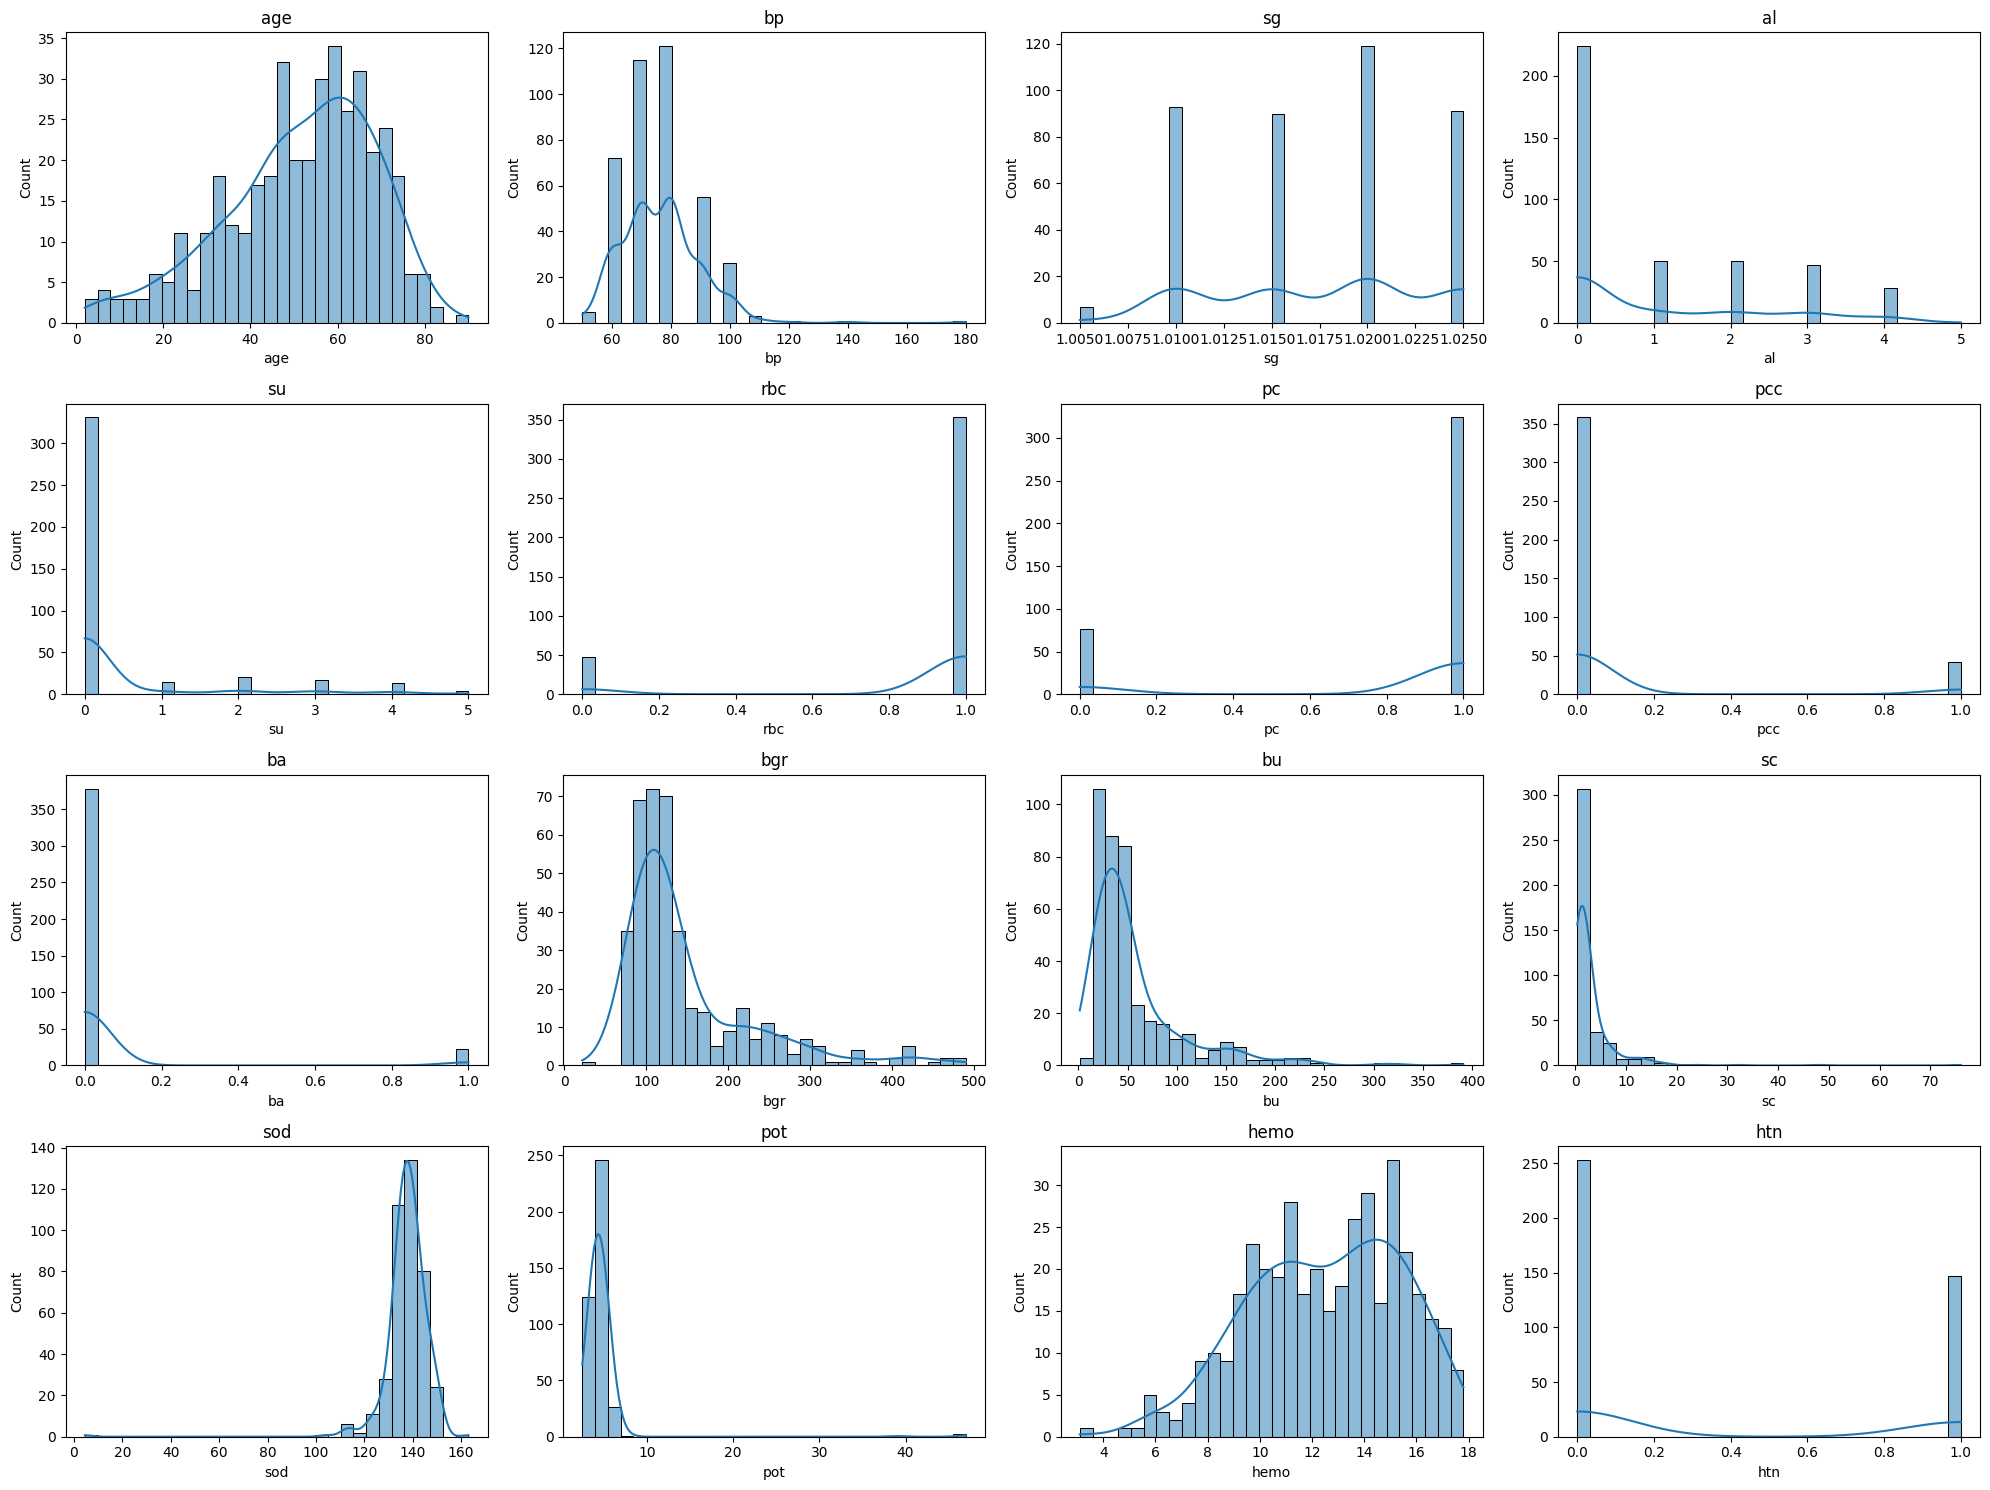

C:\Users\kalag\AppData\Local\Temp\ipykernel_27440\4282804055.py:27: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kalag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


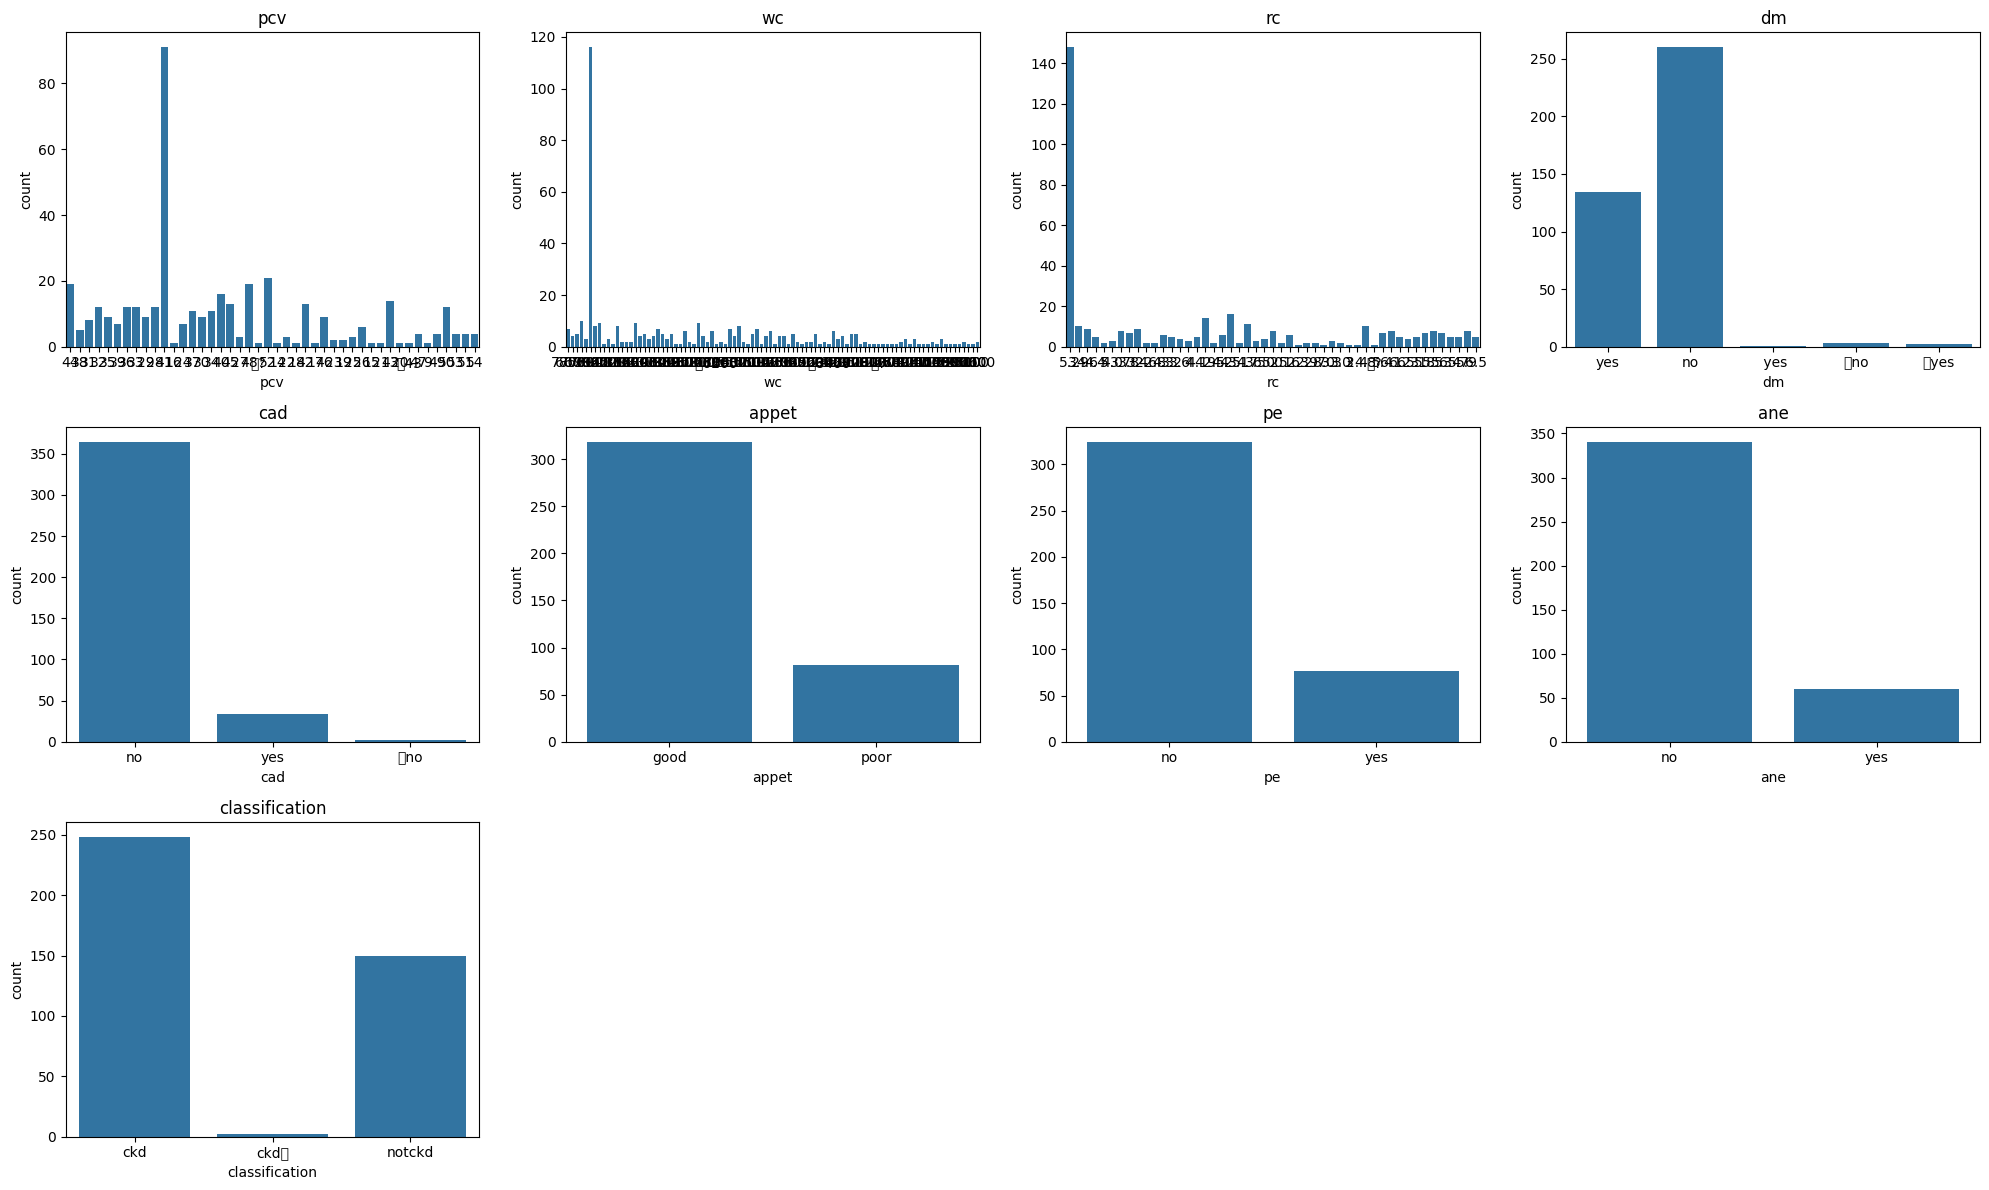

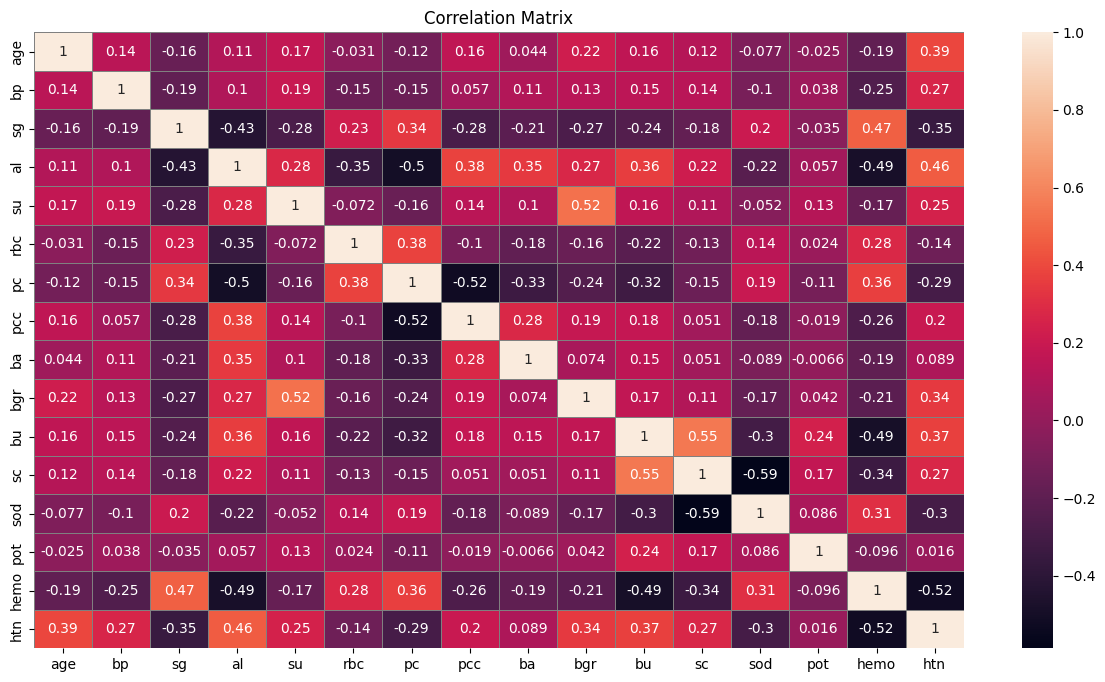

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Strip whitespace from column names
df.columns = df.columns.str.strip()

# 2️⃣ Define numeric and categorical columns safely
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# 3️⃣ Distribution of numeric columns
plt.figure(figsize=(20,15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# 4️⃣ Count plots of categorical columns (only if column exists)
plt.figure(figsize=(20,12))
for i, col in enumerate(cat_cols, 1):
    if col in df.columns:
        plt.subplot(3, 4, i)
        sns.countplot(x=col, data=df)
        plt.title(col)
plt.tight_layout()
plt.show()

# 5️⃣ Correlation heatmap (numeric columns only)
plt.figure(figsize=(15,8))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=0.5, linecolor='gray')
plt.title("Correlation Matrix")
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# 1️⃣ Strip whitespace from column names
df.columns = df.columns.str.strip()

# 2️⃣ Use the correct target column
target_col = 'classification'

if target_col not in df.columns:
    raise KeyError(f"Column '{target_col}' not found in DataFrame. Check column names: {df.columns.tolist()}")

# 3️⃣ Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# 4️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split successful!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Data split successful!
X_train shape: (320, 24)
X_test shape: (80, 24)
y_train shape: (320,)
y_test shape: (80,)


In [21]:
# 1️⃣ Strip whitespace from all column names
df.columns = df.columns.str.strip()

# 2️⃣ Strip whitespace from target and fix values
target_col = 'classification'
df[target_col] = df[target_col].astype(str).str.strip()  # Remove tabs/spaces
df[target_col] = df[target_col].replace({'ckd\t':'ckd', 'notckd':'not ckd', 'ckd':'ckd', 'not ckd':'not ckd'})

# 3️⃣ Map target to numeric
mapping = {'ckd': 0, 'not ckd': 1}
df[target_col] = df[target_col].map(mapping)

# 4️⃣ Drop rows where target could not be mapped (NaN)
df = df.dropna(subset=[target_col])

# 5️⃣ Encode categorical features
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = LabelEncoder().fit_transform(df[col])

# 6️⃣ Convert numeric columns
numeric_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 7️⃣ Impute missing numeric values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 8️⃣ Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# 9️⃣ Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣ Train Decision Tree Classifier
dtc = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features='sqrt',
    splitter='random',
    random_state=42
)

dtc.fit(X_train, y_train)  # Train model

# 2️⃣ Predict on test set
y_pred = dtc.predict(X_test)

# 3️⃣ Evaluate
print("========== Model Evaluation ==========")
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


========== Model Evaluation ==========
✅ Accuracy: 1.0

Confusion Matrix:
 [[30]]

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



C:\Users\kalag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


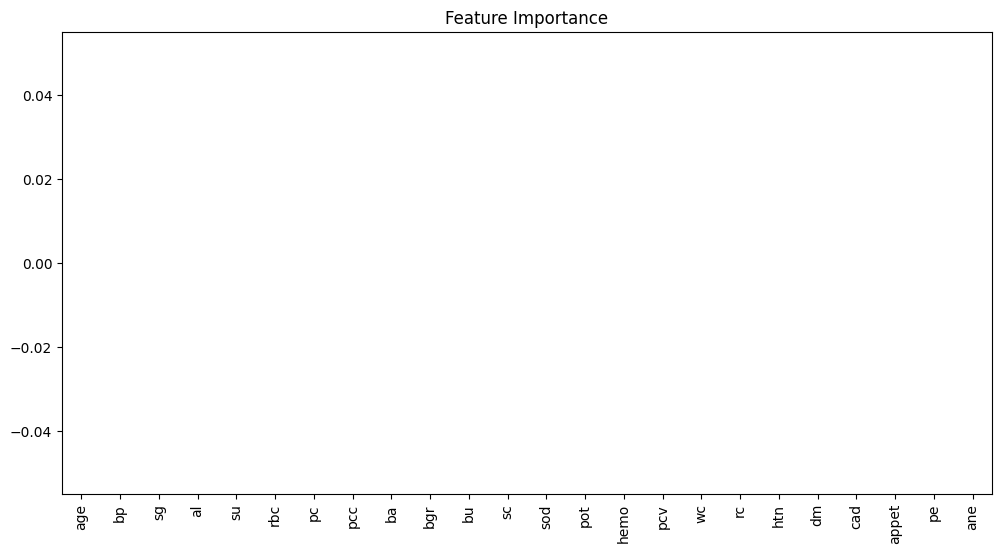

In [25]:
# ================= Feature Importance =================
plt.figure(figsize=(12,6))
feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Feature Importance")
plt.show()

In [27]:
import plotly.express as px

# Use the correct target column
target_col = 'classification'

# Plot violin plots for the first 5 numeric columns
for col in num_cols[:5]:
    if col in df.columns and target_col in df.columns:
        fig = px.violin(
            df,
            y=col,
            x=target_col,
            color=target_col,
            box=True,
            template='plotly_dark',
            title=f"Violin plot of {col} by {target_col}"
        )
        fig.show()


In [29]:
new_cols = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
            'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
            'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
            'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
            'red_blood_cell_count', 'hypertension', 'diabetes_mellitus',
            'coronary_artery_disease', 'appetite', 'peda_edema', 'aanemia', 'classification']

df.columns = new_cols
df.columns = [new_cols[i] for i in range(len(df.columns))]


In [30]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optionally, expand column width
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
df


,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,classification
250,40.0,80.0,1.025,0.0,0.0,0,0,0,0,140.0,10.0,1.2,135.0,5.0,15.0,48.0,10400.0,4.5,0,0,0,0,0,0,1.0
251,23.0,80.0,1.025,0.0,0.0,0,0,0,0,70.0,36.0,1.0,150.0,4.6,17.0,52.0,9800.0,5.0,0,0,0,0,0,0,1.0
252,45.0,80.0,1.025,0.0,0.0,0,0,0,0,82.0,49.0,0.6,147.0,4.4,15.9,46.0,9100.0,4.7,0,0,0,0,0,0,1.0
253,57.0,80.0,1.025,0.0,0.0,0,0,0,0,119.0,17.0,1.2,135.0,4.7,15.4,42.0,6200.0,6.2,0,0,0,0,0,0,1.0
254,51.0,60.0,1.025,0.0,0.0,0,0,0,0,99.0,38.0,0.8,135.0,3.7,13.0,49.0,8300.0,5.2,0,0,0,0,0,0,1.0
255,34.0,80.0,1.025,0.0,0.0,0,0,0,0,121.0,27.0,1.2,144.0,3.9,13.6,52.0,9200.0,6.3,0,0,0,0,0,0,1.0
256,60.0,80.0,1.025,0.0,0.0,0,0,0,0,131.0,10.0,0.5,146.0,5.0,14.5,41.0,10700.0,5.1,0,0,0,0,0,0,1.0
257,38.0,60.0,1.020,0.0,0.0,0,0,0,0,91.0,36.0,0.7,135.0,3.7,14.0,46.0,9100.0,5.8,0,0,0,0,0,0,1.0
258,42.0,80.0,1.020,0.0,0.0,0,0,0,0,98.0,20.0,0.5,140.0,3.5,13.9,44.0,8400.0,5.5,0,0,0,0,0,0,1.0
259,35.0,80.0,1.020,0.0,0.0,0,0,0,0,104.0,31.0,1.2,135.0,5.0,16.1,45.0,4300.0,5.2,0,0,0,0,0,0,1.0


In [31]:
df.drop_duplicates(inplace=True)


In [32]:
def random_sampling(feature):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum(), random_state=0)
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample


In [34]:
for col in ['packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [35]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optionally, expand column width
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
df

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,classification
250,40.0,80.0,1.025,0.0,0.0,0,0,0,0,140.0,10.0,1.2,135.0,5.0,15.0,48.0,10400.0,4.5,0,0,0,0,0,0,1.0
251,23.0,80.0,1.025,0.0,0.0,0,0,0,0,70.0,36.0,1.0,150.0,4.6,17.0,52.0,9800.0,5.0,0,0,0,0,0,0,1.0
252,45.0,80.0,1.025,0.0,0.0,0,0,0,0,82.0,49.0,0.6,147.0,4.4,15.9,46.0,9100.0,4.7,0,0,0,0,0,0,1.0
253,57.0,80.0,1.025,0.0,0.0,0,0,0,0,119.0,17.0,1.2,135.0,4.7,15.4,42.0,6200.0,6.2,0,0,0,0,0,0,1.0
254,51.0,60.0,1.025,0.0,0.0,0,0,0,0,99.0,38.0,0.8,135.0,3.7,13.0,49.0,8300.0,5.2,0,0,0,0,0,0,1.0
255,34.0,80.0,1.025,0.0,0.0,0,0,0,0,121.0,27.0,1.2,144.0,3.9,13.6,52.0,9200.0,6.3,0,0,0,0,0,0,1.0
256,60.0,80.0,1.025,0.0,0.0,0,0,0,0,131.0,10.0,0.5,146.0,5.0,14.5,41.0,10700.0,5.1,0,0,0,0,0,0,1.0
257,38.0,60.0,1.020,0.0,0.0,0,0,0,0,91.0,36.0,0.7,135.0,3.7,14.0,46.0,9100.0,5.8,0,0,0,0,0,0,1.0
258,42.0,80.0,1.020,0.0,0.0,0,0,0,0,98.0,20.0,0.5,140.0,3.5,13.9,44.0,8400.0,5.5,0,0,0,0,0,0,1.0
259,35.0,80.0,1.020,0.0,0.0,0,0,0,0,104.0,31.0,1.2,135.0,5.0,16.1,45.0,4300.0,5.2,0,0,0,0,0,0,1.0


In [36]:


print(df.columns)


Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'peda_edema', 'aanemia', 'classification'],
      dtype='object')
